# **Week 1: Lab Exercises for COMP499/691 Conversational AI**

## Insights on Debugging Neural Networks

Debugging neural networks is a challenging task. It often requires a profound understanding of the techniques involved.

It is therefore important to have a well-defined strategy and follow some guidelines that will simplify model debugging. In general, it is crucial to implement the model step-by-step and do several checks along the way. The worse thing you can do is implement a complex system in one shot and hope everything is working.

Here are some additional suggestions:
1. Before implementing your model, carefully check your data. Make sure, for instance, that the inputs and the labels match. If you shuffle the data, make sure to shuffle inputs and labels consistently (to avoid input-label mismatches).

2. Start with a simple model (e.g., a linear model). Remember: "*the more powerful the model the more sophisticated the bugs*". Make sure the code is running. Make sure the model is in train modality during training and eval modality during validation and test. The model will likely underfit, but you should see at least some small improvements in the training loss. If this does not happen:
- Carefully check the batches and ensure there is a matching between inputs and labels.
- Check the shapes on the tensors involved in your model and make sure they correspond to your expectations.
- Check the parameters of the network. If they remain constant, your gradient is likely zero. This can be caused by forgetting to call the backpropagation method or the step method of the optimizer.
- Make sure you applied the softmax on the right axis.
- Tweek a bit the hyperparameters of the model to see if there is at least one configuration that allows the loss to decrease a bit.
3. Implement your final model. Initialize it and make sure it runs. Fix possible dimensionality mismatch issues. Make sure all the shapes are the ones you expect.
4. Do an **overfitting test**. If your model cannot overfit on a tiny dataset (e.g., take 5-10 examples only) it likely contains a bug somewhere. To do an overfitting test, feed the model with a single batch composed of 5-10 examples. Run the model for several epochs with a pretty high learning rate. If everything is correct, you should see an almost perfect training loss and a very high validation loss. This means that the model can memorize data. Data memorization is not what we want in the end, but models that cannot overfit likely have a bug to fix.
5. Now, you can run your experiment. Check if the loss is decreasing. If you observe numerical instabilities (e.g., NaN) try to reduce the learning rate. If that does not help, consider using gradient clipping. You have to do your best to tune the hyperparameters of the model to maximize the validation performance.

Many other things can go wrong. You will progressively gain more and more experience and this will help you with debugging.

## Exercise 1 - Debugging a PyTorch Code

Let's now do a debug exercise with PyTorch.



Let's import the needed libraries:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

torch.manual_seed(1)

We want to implement a digit classification with the MNIST dataset using the following MLP:

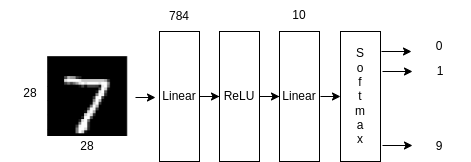

**Run the following code** that attempts to implement the aforementioned model.

In [ ]:
# Neural Network Module
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005

input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
model = Net(input_size, hidden_size, num_classes).to('cuda:0')
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader:
    outputs = model(images)
    l = loss(outputs, labels)
    l.backward()
    optimizer.step()
    losses.append(l)
  return torch.tensor(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

The code has several bugs in this code.

**Modify the code above** to fix all these bugs. Do the minimum amount of modifications needed to make the model work. Do not rewrite everything from scratch.

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Neural Network Module
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
model = Net(input_size, hidden_size, num_classes)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader: # 1.data load
    images = images.reshape(images.size(0),-1)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) # 2.train
    l = loss(outputs, labels) # 3.loss

    optimizer.zero_grad()
    l.backward() # 4.optimize
    optimizer.step() # 5.update the gradiant
    losses.append(l)
  return torch.tensor(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    images = images.reshape(images.size(0),-1)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

Epoch: 1  train_loss=0.2064, test_loss=0.1023, test_err=3.33%
Epoch: 2  train_loss=0.0837, test_loss=0.0976, test_err=2.95%
Epoch: 3  train_loss=0.0589, test_loss=0.1092, test_err=3.15%
Epoch: 4  train_loss=0.0484, test_loss=0.0797, test_err=2.21%
Epoch: 5  train_loss=0.0414, test_loss=0.1012, test_err=2.57%
Epoch: 6  train_loss=0.0321, test_loss=0.0935, test_err=2.52%
Epoch: 7  train_loss=0.0252, test_loss=0.0988, test_err=2.21%
Epoch: 8  train_loss=0.0308, test_loss=0.1197, test_err=2.57%
Epoch: 9  train_loss=0.0273, test_loss=0.1448, test_err=2.69%
Epoch: 10  train_loss=0.0277, test_loss=0.1276, test_err=2.36%
Epoch: 11  train_loss=0.0231, test_loss=0.1206, test_err=2.17%
Epoch: 12  train_loss=0.0214, test_loss=0.1399, test_err=2.48%
Epoch: 13  train_loss=0.0211, test_loss=0.1537, test_err=2.74%
Epoch: 14  train_loss=0.0232, test_loss=0.1517, test_err=2.25%
Epoch: 15  train_loss=0.0164, test_loss=0.1507, test_err=2.45%
Epoch: 16  train_loss=0.0242, test_loss=0.1430, test_err=1.96%
E

If everything is fine, you should obtain something like this:

```
Epoch: 1  train_loss=0.2042, test_loss=0.0968, test_err=3.11%
Epoch: 2  train_loss=0.0876, test_loss=0.0816, test_err=2.64%
Epoch: 3  train_loss=0.0589, test_loss=0.0827, test_err=2.42%
Epoch: 4  train_loss=0.0464, test_loss=0.1234, test_err=3.35%
Epoch: 5  train_loss=0.0413, test_loss=0.0950, test_err=2.49%
Epoch: 6  train_loss=0.0370, test_loss=0.0904, test_err=2.29%
Epoch: 7  train_loss=0.0282, test_loss=0.1006, test_err=2.24%
Epoch: 8  train_loss=0.0286, test_loss=0.1177, test_err=2.49%
Epoch: 9  train_loss=0.0269, test_loss=0.1185, test_err=2.20%
Epoch: 10  train_loss=0.0244, test_loss=0.1198, test_err=2.16%
Epoch: 11  train_loss=0.0248, test_loss=0.1093, test_err=1.97%
Epoch: 12  train_loss=0.0202, test_loss=0.1360, test_err=2.19%
Epoch: 13  train_loss=0.0249, test_loss=0.1241, test_err=2.07%
Epoch: 14  train_loss=0.0210, test_loss=0.1535, test_err=2.36%
Epoch: 15  train_loss=0.0227, test_loss=0.1486, test_err=2.28%
Epoch: 16  train_loss=0.0181, test_loss=0.1562, test_err=2.27%
Epoch: 17  train_loss=0.0190, test_loss=0.1517, test_err=2.13%
Epoch: 18  train_loss=0.0203, test_loss=0.1653, test_err=2.12%
Epoch: 19  train_loss=0.0185, test_loss=0.1533, test_err=2.10%
Epoch: 20  train_loss=0.0167, test_loss=0.1902, test_err=2.23%
```



The classification error should be around 2% (98% Accuracy).

**Fill up the following table** with the bugs you found. Describe briefly how did you fix them.


| Bug   |      How I fix it
|----------|:-------------:|
| Device Issue |  Model,input,outputs all should be in same device; created a device at the top and changed it for all |
| Dimensionality mismatched issue |  check the dimension for input image and the required for fully connected layer and reshape the images accordingly |
| Resetting the previous gradiant to zero |  use optimazer.zero_grad() before backpropagation |

## Exercise 2 - Model Improvements

The simple model of the previous exercise already has a good performance.
However, we can do it better on MNIST. For instance, you might have noticed that the model (even a small model like the one we used) tends to overfit quite quickly. In the following, we will progressively improve the model.

## Exercise 2.1 - Adding Batch Normalization
A regularization technique that normally helps is called [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization). It essentially normalizes the mean and the variance of the hidden activations over the batch axis.

**Modify the code above** to add batch normalization. Use [torch.nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) and apply it right after the first linear transformation.





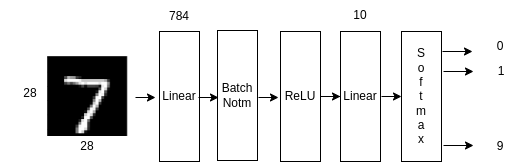

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Neural Network Module
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.bn1 = nn.BatchNorm1d(hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
model = Net(input_size, hidden_size, num_classes)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader: # 1.data load
    images = images.reshape(images.size(0),-1)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) # 2.train
    l = loss(outputs, labels) # 3.loss

    optimizer.zero_grad()
    l.backward() # 4.optimize
    optimizer.step() # 5.update the gradiant
    losses.append(l)
  return torch.tensor(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    images = images.reshape(images.size(0),-1)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 22.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 658kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.61MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch: 1  train_loss=0.1814, test_loss=0.1229, test_err=4.09%
Epoch: 2  train_loss=0.0817, test_loss=0.0673, test_err=2.11%
Epoch: 3  train_loss=0.0525, test_loss=0.0797, test_err=2.46%
Epoch: 4  train_loss=0.0383, test_loss=0.0731, test_err=2.26%
Epoch: 5  train_loss=0.0285, test_loss=0.0739, test_err=2.12%
Epoch: 6  train_loss=0.0233, test_loss=0.0801, test_err=2.26%
Epoch: 7  train_loss=0.0225, test_loss=0.0820, test_err=2.01%
Epoch: 8  train_loss=0.0207, test_loss=0.0881, test_err=2.13%
Epoch: 9  train_loss=0.0150, test_loss=0.0878, test_err=2.23%
Epoch: 10  train_loss=0.0170, test_loss=0.0865, test_err=2.18%
Epoch: 11  train_loss=0.0137, test_loss=0.0881, test_err=2.10%
Epoch: 12  train_loss=0.0120, test_loss=0.0721, test_err=1.66%
Epoch: 13  train_loss=0.0123, test_loss=0.0896, test_err=1.94%
Epoch: 14  train_loss=0.0119, test_loss=0.0841, test_err=1.99%
Epoch: 15  train_loss=0.0136, test_loss=0.0789, test_err=1.86%
Epoch: 16  train_loss=0.0081, test_loss=0.0779, test_err=1.81%
E

If everything goes well, you should get something like this:


```
Epoch: 1  train_loss=0.1814, test_loss=0.1229, test_err=4.09%
Epoch: 2  train_loss=0.0816, test_loss=0.0670, test_err=2.19%
Epoch: 3  train_loss=0.0523, test_loss=0.0782, test_err=2.42%
Epoch: 4  train_loss=0.0386, test_loss=0.0739, test_err=2.33%
Epoch: 5  train_loss=0.0296, test_loss=0.0731, test_err=2.04%
Epoch: 6  train_loss=0.0251, test_loss=0.0828, test_err=2.12%
Epoch: 7  train_loss=0.0220, test_loss=0.0751, test_err=1.99%
Epoch: 8  train_loss=0.0181, test_loss=0.0988, test_err=2.34%
Epoch: 9  train_loss=0.0168, test_loss=0.0771, test_err=1.90%
Epoch: 10  train_loss=0.0149, test_loss=0.0781, test_err=1.99%
Epoch: 11  train_loss=0.0153, test_loss=0.0930, test_err=2.47%
Epoch: 12  train_loss=0.0122, test_loss=0.1029, test_err=2.31%
Epoch: 13  train_loss=0.0146, test_loss=0.1006, test_err=2.27%
Epoch: 14  train_loss=0.0110, test_loss=0.0922, test_err=2.02%
Epoch: 15  train_loss=0.0117, test_loss=0.0860, test_err=2.04%
Epoch: 16  train_loss=0.0092, test_loss=0.0818, test_err=1.84%
Epoch: 17  train_loss=0.0079, test_loss=0.0933, test_err=1.98%
Epoch: 18  train_loss=0.0075, test_loss=0.0840, test_err=1.87%
Epoch: 19  train_loss=0.0102, test_loss=0.1054, test_err=2.16%
Epoch: 20  train_loss=0.0096, test_loss=0.0950, test_err=1.89%
```



The best test error is about 1.90%.
As you can see, there is a little improvement in the performance when adding batch normalization.

## Exercise 2.2 - Adding Dropout

Another popular regularization technique is [dropout](https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9). It randomly drops neurons to prevent coadaptation.

**Modify the code above** to introduce dropout. Use [torch.nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and apply it right after the ReLU activations. Use a dropout factor of 0.5.

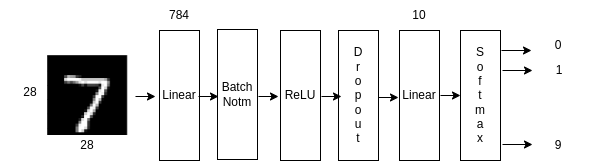

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Neural Network Module
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.bn1 = nn.BatchNorm1d(hidden_size)
    self.relu = nn.ReLU()
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.dropout1(out)
    out = self.fc2(out)
    return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
model = Net(input_size, hidden_size, num_classes)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader: # 1.data load
    images = images.reshape(images.size(0),-1)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) # 2.train
    l = loss(outputs, labels) # 3.loss

    optimizer.zero_grad()
    l.backward() # 4.optimize
    optimizer.step() # 5.update the gradiant
    losses.append(l)
  return torch.tensor(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    images = images.reshape(images.size(0),-1)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

Epoch: 1  train_loss=0.2463, test_loss=0.1250, test_err=3.88%
Epoch: 2  train_loss=0.1380, test_loss=0.0893, test_err=2.68%
Epoch: 3  train_loss=0.1082, test_loss=0.0709, test_err=2.28%
Epoch: 4  train_loss=0.0917, test_loss=0.0661, test_err=2.14%
Epoch: 5  train_loss=0.0824, test_loss=0.0638, test_err=2.14%
Epoch: 6  train_loss=0.0727, test_loss=0.0631, test_err=1.84%
Epoch: 7  train_loss=0.0666, test_loss=0.0650, test_err=1.92%
Epoch: 8  train_loss=0.0616, test_loss=0.0612, test_err=1.85%
Epoch: 9  train_loss=0.0590, test_loss=0.0581, test_err=1.77%
Epoch: 10  train_loss=0.0523, test_loss=0.0613, test_err=1.86%
Epoch: 11  train_loss=0.0522, test_loss=0.0615, test_err=1.88%
Epoch: 12  train_loss=0.0493, test_loss=0.0605, test_err=1.76%
Epoch: 13  train_loss=0.0441, test_loss=0.0642, test_err=1.80%
Epoch: 14  train_loss=0.0456, test_loss=0.0585, test_err=1.70%
Epoch: 15  train_loss=0.0420, test_loss=0.0605, test_err=1.74%
Epoch: 16  train_loss=0.0403, test_loss=0.0611, test_err=1.63%
E

If everything works well, you should see the following output:



```
Epoch: 1  train_loss=0.2432, test_loss=0.1191, test_err=3.82%
Epoch: 2  train_loss=0.1398, test_loss=0.0780, test_err=2.52%
Epoch: 3  train_loss=0.1083, test_loss=0.0789, test_err=2.49%
Epoch: 4  train_loss=0.0933, test_loss=0.0722, test_err=2.37%
Epoch: 5  train_loss=0.0834, test_loss=0.0639, test_err=2.07%
Epoch: 6  train_loss=0.0730, test_loss=0.0657, test_err=2.07%
Epoch: 7  train_loss=0.0671, test_loss=0.0618, test_err=1.82%
Epoch: 8  train_loss=0.0635, test_loss=0.0642, test_err=2.05%
Epoch: 9  train_loss=0.0580, test_loss=0.0572, test_err=1.77%
Epoch: 10  train_loss=0.0563, test_loss=0.0593, test_err=1.79%
Epoch: 11  train_loss=0.0517, test_loss=0.0604, test_err=1.87%
Epoch: 12  train_loss=0.0485, test_loss=0.0568, test_err=1.77%
Epoch: 13  train_loss=0.0456, test_loss=0.0621, test_err=1.75%
Epoch: 14  train_loss=0.0488, test_loss=0.0536, test_err=1.63%
Epoch: 15  train_loss=0.0437, test_loss=0.0572, test_err=1.73%
Epoch: 16  train_loss=0.0406, test_loss=0.0593, test_err=1.59%
Epoch: 17  train_loss=0.0409, test_loss=0.0571, test_err=1.71%
Epoch: 18  train_loss=0.0410, test_loss=0.0564, test_err=1.53%
Epoch: 19  train_loss=0.0367, test_loss=0.0626, test_err=1.70%
Epoch: 20  train_loss=0.0371, test_loss=0.0608, test_err=1.51%
```



Dropout further improves the performance. Now, the best test error should be around 1.5%.

## Exercise 2.3 - Add a Convolutional FrontEnd

Let's now add to the model above a convolutional block before the fully-connected one.
The convolutional block should contain the following sequence of operations (in the specified order):
1. 2D convolution with 20 channels and a kernel size of (5,5). Use [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).
2. 2D Batch normalization (use [torch.nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)).
3. 2D Max pooling with a pool size of 2 (use [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)).
4. ReLU activation function.

Hint: compute the new input dimensionality of the first linear layer in the initialization method (avoid hard-coding it). Check the documentation of the conv2d and maxpoll2d methods to estimate it. In the forward method, you can use torch.flatten() or .reshape() to get the expected tensor dimensionality in input to the first linear layer.

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Neural Network Module
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()

    #here the input of the image from MNIST is (128,1,28,28) => (3584,28)

    self.conv1 = nn.Conv2d(in_channels=1,out_channels=20,kernel_size=5,stride=1,padding=1)
    self.bn2d = nn.BatchNorm2d(num_features=20)
    self.maxP2d = nn.MaxPool2d(2)

    #after conv1 layer the image becomes (128,20,26,26) => (66560, 26)
    #after the max pool layer it becomes (128,20,13,13) => (33280,13)

    #but the fc1 takes (128,784)

    #so we need to flat change the input size

    converted_input_size = 20* 13 *13


    self.fc1 = nn.Linear(converted_input_size, hidden_size)
    self.bn1 = nn.BatchNorm1d(hidden_size)
    self.relu = nn.ReLU()
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):

    out = self.conv1(x)
    out = self.bn2d(out)
    out = self.maxP2d(out)
    out = self.relu(out)

    out = out.reshape(out.size(0), -1)


    out = self.fc1(out)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.dropout1(out)
    out = self.fc2(out)
    return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
model = Net(input_size, hidden_size, num_classes)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader: # 1.data load
    # images = images.reshape(images.size(0),-1)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) # 2.train
    l = loss(outputs, labels) # 3.loss

    optimizer.zero_grad()
    l.backward() # 4.optimize
    optimizer.step() # 5.update the gradiant
    losses.append(l)
  return torch.tensor(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    # images = images.reshape(images.size(0),-1)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.20MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch: 1  train_loss=0.1369, test_loss=0.0512, test_err=1.70%
Epoch: 2  train_loss=0.0643, test_loss=0.0462, test_err=1.57%
Epoch: 3  train_loss=0.0459, test_loss=0.0347, test_err=1.12%
Epoch: 4  train_loss=0.0373, test_loss=0.0371, test_err=1.21%
Epoch: 5  train_loss=0.0302, test_loss=0.0398, test_err=1.14%
Epoch: 6  train_loss=0.0266, test_loss=0.0357, test_err=1.12%
Epoch: 7  train_loss=0.0261, test_loss=0.0385, test_err=1.10%
Epoch: 8  train_loss=0.0226, test_loss=0.0493, test_err=1.29%
Epoch: 9  train_loss=0.0217, test_loss=0.0330, test_err=0.94%
Epoch: 10  train_loss=0.0202, test_loss=0.0345, test_err=1.01%
Epoch: 11  train_loss=0.0169, test_loss=0.0406, test_err=1.12%
Epoch: 12  train_loss=0.0182, test_loss=0.0451, test_err=1.14%
Epoch: 13  train_loss=0.0182, test_loss=0.0380, test_err=0.95%
Epoch: 14  train_loss=0.0160, test_loss=0.0412, test_err=0.95%
Epoch: 15  train_loss=0.0120, test_loss=0.0427, test

If everything is correct, you should see something like this:


```
Epoch: 1  train_loss=0.1512, test_loss=0.0464, test_err=1.46%
Epoch: 2  train_loss=0.0684, test_loss=0.0473, test_err=1.70%
Epoch: 3  train_loss=0.0509, test_loss=0.0349, test_err=1.14%
Epoch: 4  train_loss=0.0450, test_loss=0.0303, test_err=0.91%
Epoch: 5  train_loss=0.0387, test_loss=0.0413, test_err=1.15%
Epoch: 6  train_loss=0.0393, test_loss=0.0407, test_err=1.15%
Epoch: 7  train_loss=0.0328, test_loss=0.0375, test_err=1.02%
Epoch: 8  train_loss=0.0290, test_loss=0.0468, test_err=1.28%
Epoch: 9  train_loss=0.0310, test_loss=0.0394, test_err=1.12%
Epoch: 10  train_loss=0.0304, test_loss=0.0374, test_err=1.05%
Epoch: 11  train_loss=0.0313, test_loss=0.0437, test_err=1.09%
Epoch: 12  train_loss=0.0268, test_loss=0.0548, test_err=1.35%
Epoch: 13  train_loss=0.0293, test_loss=0.0536, test_err=1.20%
Epoch: 14  train_loss=0.0265, test_loss=0.0472, test_err=1.14%
Epoch: 15  train_loss=0.0234, test_loss=0.0479, test_err=1.05%
Epoch: 16  train_loss=0.0215, test_loss=0.0422, test_err=0.88%
Epoch: 17  train_loss=0.0211, test_loss=0.0419, test_err=0.94%
Epoch: 18  train_loss=0.0218, test_loss=0.0473, test_err=1.00%
Epoch: 19  train_loss=0.0205, test_loss=0.0485, test_err=0.96%
Epoch: 20  train_loss=0.0215, test_loss=0.0503, test_err=0.90%

```



The convolutional front-end helps improve performance significantly. Now, the best performance on the test set should be between 0.8%-0.9%.

**Note**: in this tutorial, we use relatively simple models. When models get more complex (e.g, you have more layers and types of neural networks involved) you can split your models into submodels and then combine them. You can also use a sequential container ([torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to combine pipelines of computations (without the need to write the forward method yourself).